## COMENTARIOS DE LA CORRECCIÓN

**Comentario del Revisor #1**

Aquí lo mejor es no mostrar los outliers para poder ver más claramente las cajas y poder realizar comparativas. (gráfico de caja, muchos outliers hicieron que las cajas sean muy pequeñas)

**Comentario del Revisor #2**

(Gráfico de Top 5 plataformas)

Al analizar plataformas y géneros, todo lo que no esté incluido en el TOP-5 podría combinarse en "otros", para que la imagen del análisis sea más completa.

**Comentario del Revisor #3**

Al realizar una prueba de hipótesis, es muy importante verificar los supuestos. El t-test que usaste funciona bien cuando se cumplen ciertos supuestos, como que las varianzas de ambos grupos (sábados lluviosos y no lluviosos) sean similares. Puedes realizar la prueba de levene para comprobar que los dos grupos tienen la misma varianza y, de esta forma, podrás saber el valor del parámetro equal_var que se debe utilizar en la función stats.ttest_ind.

**Comentario del Revisor #4**:

He notado que hay fragmentos de código repetidos en ambos procesos. Sería recomendable encapsularlos en funciones para mejorar la reutilización y mantener un código más limpio y modular.

## Inicialización

In [ ]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from scipy.stats import zscore

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carga de datos

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Triple Ten/Proyecto S6/games.csv")

## Paso 1 - Exploración inicial
- Vemos info general del dataset.
- Revisamos tipos, valores nulos y primeras filas.

In [ ]:
# información general/resumida del DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


Vamos a convertir los **nombres de las columnas a minúscula**s para facilitar el análisis futuro.

Vemos que hay columnas con **valores ausentes**, así que evaluaremos caso por caso cómo completarlos o eliminarlos.

El tipo de la columna **'year of release'** es float, por lo que lo evaluaremos convertirla a tipo **entero**. Además, la de **'user score'** es de tipo object, siendo que contiene números decimales, así que la convertiremos a tipo **float.**

In [ ]:
# primeras filas
print(df.head(10))

                        Name Platform  Year_of_Release         Genre  \
0                 Wii Sports      Wii           2006.0        Sports   
1          Super Mario Bros.      NES           1985.0      Platform   
2             Mario Kart Wii      Wii           2008.0        Racing   
3          Wii Sports Resort      Wii           2009.0        Sports   
4   Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
5                     Tetris       GB           1989.0        Puzzle   
6      New Super Mario Bros.       DS           2006.0      Platform   
7                   Wii Play      Wii           2006.0          Misc   
8  New Super Mario Bros. Wii      Wii           2009.0      Platform   
9                  Duck Hunt      NES           1984.0       Shooter   

   NA_sales  EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     41.36     28.96      3.77         8.45          76.0          8      E  
1     29.08      3.58      6.81         0.77     

In [ ]:
# valores nulos
df.isna().sum()

,0
Name,2
Platform,0
Year_of_Release,269
Genre,2
NA_sales,0
EU_sales,0
JP_sales,0
Other_sales,0
Critic_Score,8578
User_Score,6701


In [ ]:
# valores duplicados
df.duplicated().sum()

np.int64(0)

In [ ]:
# describe
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


## Paso 2 — Preparación de los datos

Acciones a realizar:

- Poner nombres de columnas en minúsculas.
- Revisar y ajustar tipos de datos.
- Tratar valores ausentes y explicar decisiones
- Crear una columna `'ventas_totales'` que será la suma de `'na_sales'`, `'eu_sales'`, `'jp_sales'`, y `'other_sales'`

In [ ]:
# pasar columnas a minúscula
df.columns = df.columns.str.lower()
df.columns


Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Valores ausentes y cambio de tipo de datos

Evaluemos la situación de **valores ausentes** en la columna `year_of_release`, ya que para pasarla a tipo **entero** primero debe estar **completa.**

In [ ]:
# valores nulos de 'year_of_release'
df['year_of_release'].isna().sum()

np.int64(269)

In [ ]:
# vemos qué valores únicos tenemos en la columna y cuántas veces aparecen
print(df['year_of_release'].value_counts().head(10))
print(df['year_of_release'].unique())

year_of_release
2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     939
2002.0     829
2003.0     775
2004.0     762
Name: count, dtype: int64
[2006. 1985. 2008. 2009. 1996. 1989. 1984. 2005. 1999. 2007. 2010. 2013.
 2004. 1990. 1988. 2002. 2001. 2011. 1998. 2015. 2012. 2014. 1992. 1997.
 1993. 1994. 1982. 2016. 2003. 1986. 2000.   nan 1995. 1991. 1981. 1987.
 1980. 1983.]


In [ ]:
# vimos que tenemos 269 valores ausentes en dicha columna
# veamos qué porcentaje representan
print(f"Porcentaje: {df['year_of_release'].isna().mean()*100:.1f}%")

Porcentaje: 1.6%


Como los **valores ausentes** representan sólo un **1.6% de los datos**, procedemos a **eliminar dichas filas** ya que al ser **menos del 5%** de nuestra base de datos igual nos mantenemos en nuestro límite de confianza de nuestro estudio.

In [ ]:
# eliminamos filas con valores ausentes en 'year_of_release'
df = df.dropna(subset=['year_of_release'])

# cambiamos el tipo de datos que contiene a tipo entero
df['year_of_release'] = df['year_of_release'].astype(int)

Ahora evaluemos el caso de la columna `'name'`

In [ ]:
# valores nulos de 'name'
df['name'].isna().sum()

np.int64(2)

Faltan sólo 2 nombres. Podríamos eliminarlos sin afectar en gran medida nuestro análisis, pero por ahora podemos completarlos con 'unknown'

In [ ]:
# completamos valores nulos
df['name'] = df['name'].fillna('unknown')

Ahora evaluemos el caso de la columna `'genre'`

In [ ]:
# valores nulos de 'genre'
df['genre'].isna().sum()

np.int64(2)

Nuevamente faltan sólo 2 valores. Podríamos eliminarlos sin afectar en gran medida nuestro análisis, pero por ahora podemos completarlos con 'unknown'

In [ ]:
# completamos valores nulos
df['genre'] = df['genre'].fillna('unknown')

Ahora evaluemos el caso de la columna `'user_score'`



In [ ]:
# valores nulos de 'user_score'
df['user_score'].isna().sum()

np.int64(6607)

In [ ]:
# sabemos que tenemos 6607 valores ausentes
# veamos qué porcentaje representan
print(f"Porcentaje: {df['user_score'].isna().mean()*100:.1f}%")

Porcentaje: 40.2%


Que el **40%** de la columna tenga **datos ausentes** es un valor muy alto para eliminarlos, así que procederemos a evaluar la mejor forma de **completarlos** o si es mejor **dejarlos vacíos**.

In [ ]:
# vemos qué valores únicos tenemos en la columna y cuántas veces aparecen
print(df['user_score'].value_counts().head(10))
print(df['user_score'].unique())

user_score
tbd    2376
7.8     322
8       285
8.2     276
8.3     252
7.5     249
8.5     247
7.9     246
8.1     237
7.7     236
Name: count, dtype: int64
['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


In [ ]:
# convertimos todos los 'tbd' a NaN y toda la columna a float
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

**Decisión:** Convertir valores "tbd" a NaN y transformar user_score a tipo numérico.

**Justificación:**
- "tbd" significa "to be determined", no es una calificación real
- Los valores NaN permiten que pandas maneje automáticamente los faltantes en cálculos
- Si completáramos con valores estadísticos como la media o la mediana, estaríamos adjudicando puntuaciones falsas a ciertos juegos, por lo que para conservar la veracidad de los datos es mejor dejarlos ausentes.

Ahora evaluemos el caso de la columna `critic_score`

In [ ]:
# valores nulos de critic_score
df['critic_score'].isna().sum()

np.int64(8463)

In [ ]:
# sabemos que tenemos 8463 valores ausentes
# veamos qué porcentaje representan
print(f"Porcentaje: {df['critic_score'].isna().mean()*100:.1f}%")

Porcentaje: 51.5%


Que el **>50%** de la columna tenga **datos ausentes** es un valor muy alto para eliminarlos, así que procederemos a evaluar la mejor forma de **completarlos** o si es mejor **dejarlos vacíos**.*texto en cursiva*

In [ ]:
# vemos qué valores únicos tenemos en la columna y cuántas veces aparecen
print(df['critic_score'].value_counts().head(10))
print(df['critic_score'].unique())

critic_score
70.0    252
71.0    248
75.0    240
80.0    235
73.0    234
78.0    233
76.0    228
74.0    223
72.0    223
77.0    218
Name: count, dtype: int64
[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 41. 36. 31.
 27. 35. 26. 19. 28. 23. 24. 21. 17. 13.]


**Decisión:** Conservar los valores ausentes, visto que representan un gran porcentaje de la base de datos.

**Justificación:**

- Si completamos con valores estadísticos como la media o la mediana, estaríamos adjudicando puntuaciones falsas a ciertos juegos, por lo que para conservar la veracidad de los datos es mejor dejarlos ausentes.

Finalmente, evaluemos el caso de la columna `rating`

In [ ]:
# valores nulos de rating
df['rating'].isna().sum()

np.int64(6678)

In [ ]:
# sabemos que tenemos 6678 valores ausentes
# veamos qué porcentaje representan
print(f"Porcentaje: {df['rating'].isna().mean()*100:.1f}%")

Porcentaje: 40.6%


Nuevamente, un alto porcentaje (>**40%**) de **valores ausentes**. Es un valor muy alto para eliminarlos, así que procederemos a evaluar la mejor forma de **completarlos** o si es mejor **dejarlos vacíos**.

In [ ]:
# vemos qué valores únicos tenemos en la columna y cuántas veces aparecen
print(df['rating'].value_counts().head(10))
print(df['rating'].unique())

rating
E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: count, dtype: int64
['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


**Decisión:** Reemplazar los valores ausentes por **RP** (Rating Pending, puntuacion/evaluación pendiente), para que conserven su nulidad de información.

**Justificación:**

Si completamos con valores estadísticos como la moda, estaríamos adjudicando puntuaciones falsas a ciertos juegos, por lo que para conservar la veracidad de los datos es mejor dejarlos ausentes (pero con un valor de relleno que ya existe en la base de datos).

In [ ]:
df['rating'] = df['rating'].fillna('RP')

In [ ]:
# verificamos que ya no hayan valores ausentes
print(df['rating'].unique())

['E' 'RP' 'M' 'T' 'E10+' 'K-A' 'AO' 'EC']


Por último, agregaremos una columna numérica para 'convertir' los datos categóricos de la columna 'rating' a números que luego podremos usar para calcular su correlación con ventas totales por región.

In [ ]:
# mapeamos los ratings a valores numéricos
rating_map = {
    'RP': 0,     # Rating Pending
    'EC': 1,     # Early Childhood
    'K-A': 2,    # Kids to Adults (antiguo equivalente a E)
    'E': 3,      # Everyone
    'E10+': 4,   # Everyone 10+
    'T': 5,      # Teen
    'M': 6,      # Mature
    'AO': 7      # Adults Only
}

df['rating_num'] = df['rating'].map(rating_map)

print(df.head(10))

                        name platform  year_of_release         genre  \
0                 Wii Sports      Wii             2006        Sports   
1          Super Mario Bros.      NES             1985      Platform   
2             Mario Kart Wii      Wii             2008        Racing   
3          Wii Sports Resort      Wii             2009        Sports   
4   Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
5                     Tetris       GB             1989        Puzzle   
6      New Super Mario Bros.       DS             2006      Platform   
7                   Wii Play      Wii             2006          Misc   
8  New Super Mario Bros. Wii      Wii             2009      Platform   
9                  Duck Hunt      NES             1984       Shooter   

   na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score rating  \
0     41.36     28.96      3.77         8.45          76.0         8.0      E   
1     29.08      3.58      6.81         0.77 

Resumen de la lógica empleada para el tratamiento de valores ausentes:

- **Independencia de los datos:** Cada juego es único, sus puntuaciones no dependen de otros juegos
- **Falsificación de información:** Imputar con media/mediana crearía puntuaciones "inventadas"
- **Porcentaje significativo:** Con >40% faltante, estaríamos creando casi la mitad de los datos artificialmente
- **Naturaleza de los datos:** Las puntuaciones son evaluaciones subjetivas específicas de cada juego

Creo que la decisión de mantener NaN es la más ética y metodológicamente correcta porque:

- **Preserva la veracidad:** Solo trabajamos con datos reales
- **Transparencia:** Es claro qué datos existen vs. cuáles faltan
- **Flexibilidad analítica:** Podemos decidir por análisis si incluir/excluir faltantes
- **Evita sesgos:** No introducimos patrones artificiales en los datos

Ahora, creamos la columna de `'ventas_totales'` sumando las ventas de `'na_sales'`, `'eu_sales'`, `'jp_sales'`, y `'other_sales'`, a su vez que una columna de `'ventas_score'`para mostrar el rendimiento relativo comparando entre plataformas.

In [ ]:
columnas_ventas = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

df['ventas_totales'] = df[columnas_ventas].sum(axis=1)

#df['ventas_score']= zscore(df[columnas_ventas], axis=1).mean(axis=1)
df['ventas_score'] = (zscore(df['na_sales']) +
                    zscore(df['eu_sales']) +
                    zscore(df['jp_sales']) +
                    zscore(df['other_sales'])) / 4
df.head(20)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_num,ventas_totales,ventas_score
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,3,82.54,40.911799
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP,0,40.24,16.867629
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,3,35.52,18.227895
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,3,32.77,16.441548
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP,0,31.38,17.093458
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,RP,0,30.26,12.085943
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,3,29.80,16.730360
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,3,28.91,14.646477
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,3,28.32,14.312450
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,RP,0,28.31,9.108371


Finalmente, verifiquemos si tenemos duplicados implícitos en la columna de `'platform'` y `'genre'`

In [ ]:
df['platform'].value_counts().sort_index(ascending=False)

,count
platform,
XOne,247
XB,803
X360,1232
WiiU,147
Wii,1286
WS,6
TG16,2
SNES,239
SCD,6


Pareciera no haber duplicados implícitos en la columna de `'platform'`

In [ ]:
df['genre'].value_counts().sort_index(ascending=False)

,count
genre,
unknown,2
Strategy,673
Sports,2306
Simulation,857
Shooter,1296
Role-Playing,1481
Racing,1226
Puzzle,569
Platform,878


Pareciera no haber duplicados implícitos en la columna de `'genre'`

## Paso 3 — Análisis exploratorio
**Tareas principales:**

- ¿Cuántos **juegos** se registran por **año**? ¿Los **datos** por año son **suficientes**?
- ¿Cómo varían las **ventas totales** entre **plataformas**? ¿Qué **plataformas** son **líderes**?¿Qué plataformas **crecen** y cuáles se **reducen**?
- Evaluar tendencias de **aparición** y **desaparición** de plataformas.
- Seleccionar el **periodo de interés** para **modelado** (a partir de la distribución por años).
- Boxplot de **ventas totales** por **plataforma.**
- **Correlación entre medidas** ('critic_score', 'user_score') y 'ventas_totales' y **comparación** de mismos **juegos** en varias **plataformas**.
- Distribución de **géneros** y cuáles tienen mayores **ventas totales** (más exitosos).

### ¿Cuántos juegos se registran por año? ¿Los datos por año son suficientes?

In [ ]:
# juegos por año
df.groupby('year_of_release').size()

,0
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


Vemos que los datos comienzan a ser suficientes (>30) a partir de 1991. Antes de eso, sólo contamos con 2 años que tienen datos suficientes (1981 con	46 juegos y 1982 con 36)

Creamos un gráfico para visualizar los datos:

/tmp/ipython-input-2836276877.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='year_of_release', palette='Set2')


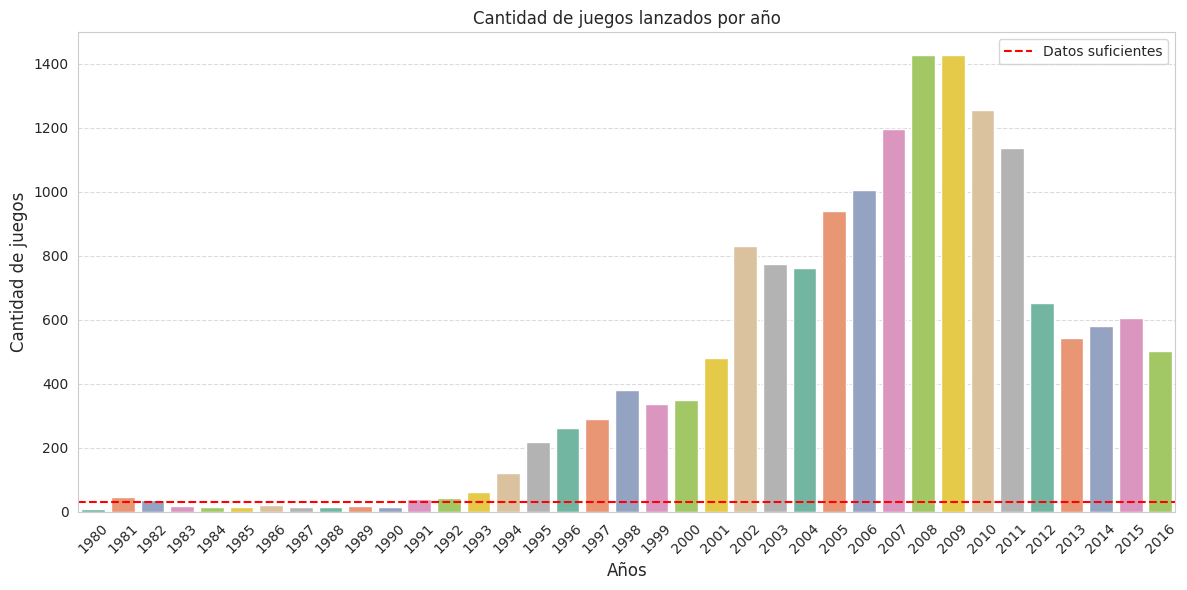

In [ ]:
# creamos el gráfico
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='year_of_release', palette='Set2')

# personalizamos
plt.xlabel('Años', fontsize=12)
plt.ylabel('Cantidad de juegos', fontsize=12)
plt.xticks(rotation=45)
plt.title('Cantidad de juegos lanzados por año')
plt.axhline(30, color='red', linestyle='--', label='Datos suficientes')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# mostramos
plt.legend()
plt.tight_layout()
plt.show()

###¿Cómo varían las ventas_score entre plataformas? ¿Qué plataformas son líderes?¿Qué plataformas crecen y cuáles se reducen?

In [ ]:
# evaluamos las ventas totales por plataforma

ventas_por_plataforma= df.groupby('platform')['ventas_totales'].sum().sort_values(ascending=False)
print(ventas_por_plataforma)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       255.76
GB       254.43
XB       251.57
NES      251.05
N64      218.01
SNES     200.04
GC       196.73
XOne     159.32
2600      86.48
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       30.77
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: ventas_totales, dtype: float64


/tmp/ipython-input-1792683395.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ventas_por_plataforma.index, y=ventas_por_plataforma.values, palette='Set2')


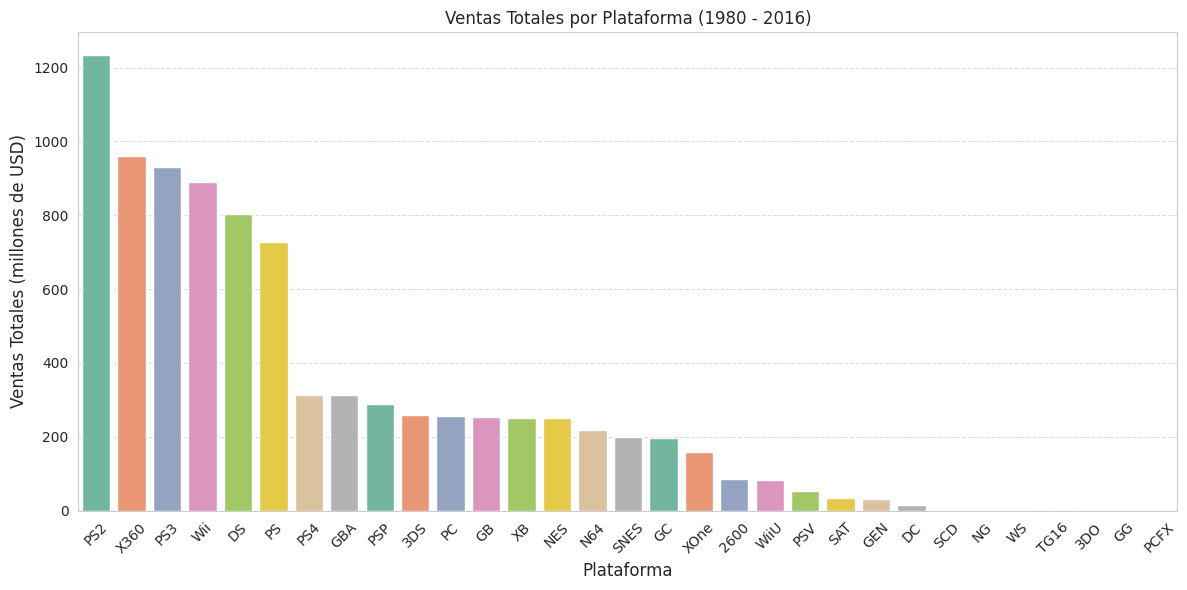

In [ ]:
# graficamos los datos obtenidos

plt.figure(figsize=(12, 6))
sns.barplot(x=ventas_por_plataforma.index, y=ventas_por_plataforma.values, palette='Set2')

# Personalizamos
plt.xlabel('Plataforma', fontsize=12)
plt.ylabel('Ventas Totales (millones de USD)', fontsize=12)
plt.xticks(rotation=45)
plt.title('Ventas Totales por Plataforma (1980 - 2016)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostramos
plt.tight_layout()
plt.show()

In [ ]:
# 5 plataformas top ventas
top_plataformas = df.groupby('platform')['ventas_totales'].sum().sort_values(ascending=False).head(5).index.tolist()
df_top_plataformas = df[df['platform'].isin(top_plataformas)]

print(top_plataformas)
print(df_top_plataformas.head(5))

['PS2', 'X360', 'PS3', 'Wii', 'DS']
                    name platform  year_of_release     genre  na_sales  \
0             Wii Sports      Wii             2006    Sports     41.36   
2         Mario Kart Wii      Wii             2008    Racing     15.68   
3      Wii Sports Resort      Wii             2009    Sports     15.61   
6  New Super Mario Bros.       DS             2006  Platform     11.28   
7               Wii Play      Wii             2006      Misc     13.96   

   eu_sales  jp_sales  other_sales  critic_score  user_score rating  \
0     28.96      3.77         8.45          76.0         8.0      E   
2     12.76      3.79         3.29          82.0         8.3      E   
3     10.93      3.28         2.95          80.0         8.0      E   
6      9.14      6.50         2.88          89.0         8.5      E   
7      9.18      2.93         2.84          58.0         6.6      E   

   rating_num  ventas_totales  ventas_score  
0           3           82.54     40.911799  


In [ ]:
# datos de cada año
top_platform_sales= df[df['platform'].isin(top_plataformas)].groupby(['year_of_release', 'platform'])['ventas_totales'].sum().reset_index()

print(top_platform_sales)

    year_of_release platform  ventas_totales
0              1985       DS            0.02
1              2000      PS2           39.17
2              2001      PS2          166.43
3              2002      PS2          205.38
4              2003      PS2          184.31
5              2004       DS           17.27
6              2004      PS2          211.81
7              2005       DS          130.14
8              2005      PS2          160.66
9              2005     X360            8.25
10             2006       DS          119.81
11             2006      PS2          103.42
12             2006      PS3           20.96
13             2006      Wii          137.15
14             2006     X360           51.62
15             2007       DS          146.94
16             2007      PS2           75.99
17             2007      PS3           73.19
18             2007      Wii          152.77
19             2007     X360           95.41
20             2008       DS          145.31
21        

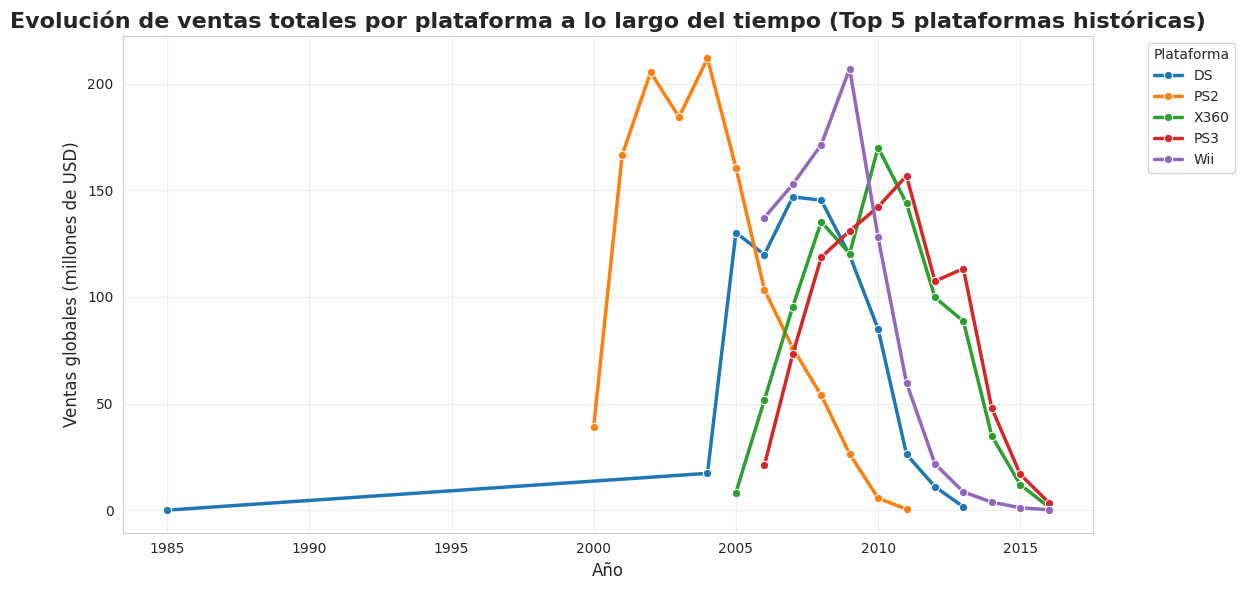

In [ ]:
# graficamos la distribución de ventas totales por plataforma por año con un gráfico de líneas múltiples

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_platform_sales,
             x='year_of_release',
             y='ventas_totales',
             hue='platform',
             marker='o',
             linewidth=2.5)

# personalizamos
plt.title('Evolución de ventas totales por plataforma a lo largo del tiempo (Top 5 plataformas históricas)',
          fontsize=16, fontweight='bold')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Ventas globales (millones de USD)', fontsize=12)
plt.legend(title='Plataforma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

En el gráfico podemos ver cómo todas las plataformas que, a la fecha de la extracción de nuestra base de datos, eran las que mayores ventas totales registraban tuvieron su período de crecimiento, auge, y descenso, llegando a la desaparición, pasándole "la posta" a la siguiente generación de consolas.

Procedemos a averiguar el "ciclo de vida de las plataformas", es decir cuánto tardan en aparecer y desaparecer.

### Evaluar tendencias de aparición y desaparición de plataformas.

In [ ]:
# calculamos métricas por plataforma y año
platform_lifecycle = df_top_plataformas.groupby(['platform', 'year_of_release']).agg({
    'ventas_totales': 'sum',
    'name': 'count'  # cantidad de juegos
}).reset_index()

# calculamos métricas de ciclo de vida por plataforma
lifecycle_stats = []

for platform in top_plataformas:
    platform_data = platform_lifecycle[platform_lifecycle['platform'] == platform]

    if len(platform_data) > 0:
        first_year = platform_data['year_of_release'].min()
        last_year = platform_data['year_of_release'].max()
        peak_year = platform_data.loc[platform_data['ventas_totales'].idxmax(), 'year_of_release']
        total_sales = platform_data['ventas_totales'].sum()

        lifecycle_stats.append({
            'platform': platform,
            'first_year': first_year,
            'last_year': last_year,
            'peak_year': peak_year,
            'lifespan': last_year - first_year + 1,
            'years_to_peak': peak_year - first_year,
            'total_sales': total_sales
        })

lifecycle_df = pd.DataFrame(lifecycle_stats)
print(lifecycle_df.sort_values('total_sales', ascending=False).head(10))

  platform  first_year  last_year  peak_year  lifespan  years_to_peak  \
0      PS2        2000       2011       2004        12              4   
1     X360        2005       2016       2010        12              5   
2      PS3        2006       2016       2011        11              5   
3      Wii        2006       2016       2009        11              3   
4       DS        1985       2013       2007        29             22   

   total_sales  
0      1233.56  
1       961.24  
2       931.34  
3       891.18  
4       802.78  


In [ ]:
# analizamos patrones de aparición y desaparición

def analyze_platform_transitions(df, min_sales_threshold=1.0):

    platform_years = df_top_plataformas.groupby(['platform', 'year_of_release'])['ventas_totales'].sum().reset_index()

    transitions = []

    for platform in top_plataformas:
        platform_data = platform_years[platform_years['platform'] == platform].sort_values('year_of_release')

        # buscamos primer año con ventas significativas (aparición)
        significant_years = platform_data[platform_data['ventas_totales'] >= min_sales_threshold]

        if len(significant_years) > 0:
            birth_year = significant_years['year_of_release'].min()
            death_year = significant_years['year_of_release'].max()

            # Encontrar año pico
            peak_year = platform_data.loc[platform_data['ventas_totales'].idxmax(), 'year_of_release']

            transitions.append({
                'platform': platform,
                'birth_year': birth_year,
                'death_year': death_year,
                'peak_year': peak_year,
                'total_lifespan': death_year - birth_year + 1,
                'years_to_peak': peak_year - birth_year,
                'years_from_peak_to_death': death_year - peak_year
            })

    return pd.DataFrame(transitions)

transitions_df = analyze_platform_transitions(df)
print(transitions_df.sort_values('total_lifespan', ascending=False))

  platform  birth_year  death_year  peak_year  total_lifespan  years_to_peak  \
1     X360        2005        2016       2010              12              5   
0      PS2        2000        2010       2004              11              4   
2      PS3        2006        2016       2011              11              5   
3      Wii        2006        2015       2009              10              3   
4       DS        2004        2013       2007              10              3   

   years_from_peak_to_death  
1                         6  
0                         6  
2                         5  
3                         6  
4                         6  


In [ ]:
print(f"Duración promedio de las plataformas: {transitions_df['total_lifespan'].mean():.1f} años")
print(f"Tiempo promedio desde el año de lanzamiento hasta el pico: {transitions_df['years_to_peak'].mean():.1f} años")
print(f"Tiempo promedio desde el pico hasta la desaparición de la plataforma: {transitions_df['years_from_peak_to_death'].mean():.1f} años")



Duración promedio de las plataformas: 10.8 años
Tiempo promedio desde el año de lanzamiento hasta el pico: 4.0 años
Tiempo promedio desde el pico hasta la desaparición de la plataforma: 5.8 años


### Seleccionar el periodo de interés para modelado (a partir de la distribución por años).

Estamos en diciembre 2016, planificando para 2017. Basándonos en nuestros análisis:
- Las plataformas tardan **~4 años en llegar al pico**
- Duran **~10.8 años en total**
- Desde el **pico** tardan **~5.8 años en desaparecer**

Por lo tanto, para 2017 son **relevantes** las plataformas que:
1. Están en su pico o cerca (lanzadas entre 2013-2017)
2. Aún no han "muerto" (lanzadas después de 2006-2007)

In [ ]:
# período elegido para el modelo:
año_inicio = 2011  # Últimos 5-6 años de datos
año_fin = 2016     # Hasta el año actual

# Filtrar datos relevantes
df_modelo = df[(df['year_of_release'] >= año_inicio) &
               (df['year_of_release'] <= año_fin)]

df_modelo

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,rating_num,ventas_totales,ventas_score
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,6,21.05,12.404350
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,6,16.27,7.131313
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,6,14.73,6.434419
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,RP,0,14.63,7.908755
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,RP,0,14.60,7.934515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,RP,0,0.01,-0.271010
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,RP,0,0.01,-0.271010
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,RP,0,0.01,-0.271010
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,RP,0,0.01,-0.271010


In [ ]:
# 5 plataformas top ventas actuales
new_top_plataformas = df_modelo.groupby('platform')['ventas_totales'].sum().sort_values(ascending=False).head(10).index.tolist()
df_top_plataformas = df_modelo[df_modelo['platform'].isin(new_top_plataformas)]

print(new_top_plataformas)
print(df_top_plataformas.head(10))

['PS3', 'X360', 'PS4', '3DS', 'XOne', 'PC', 'Wii', 'WiiU', 'PSV', 'DS']
                              name platform  year_of_release         genre  \
16              Grand Theft Auto V      PS3             2013        Action   
23              Grand Theft Auto V     X360             2013        Action   
29  Call of Duty: Modern Warfare 3     X360             2011       Shooter   
31       Call of Duty: Black Ops 3      PS4             2015       Shooter   
33             Pokemon X/Pokemon Y      3DS             2013  Role-Playing   
34      Call of Duty: Black Ops II      PS3             2012       Shooter   
35      Call of Duty: Black Ops II     X360             2012       Shooter   
37  Call of Duty: Modern Warfare 3      PS3             2011       Shooter   
40                    Mario Kart 7      3DS             2011        Racing   
42              Grand Theft Auto V      PS4             2014        Action   

    na_sales  eu_sales  jp_sales  other_sales  critic_score  user_sco

In [ ]:
# datos de cada año
new_top_platform_sales= df_modelo[df_modelo['platform'].isin(new_top_plataformas)].groupby(['year_of_release', 'platform'])['ventas_totales'].sum().reset_index()

print(new_top_platform_sales)

    year_of_release platform  ventas_totales
0              2011      3DS           63.20
1              2011       DS           26.18
2              2011       PC           35.03
3              2011      PS3          156.78
4              2011      PSV            4.63
5              2011      Wii           59.65
6              2011     X360          143.84
7              2012      3DS           51.36
8              2012       DS           11.01
9              2012       PC           23.22
10             2012      PS3          107.36
11             2012      PSV           16.19
12             2012      Wii           21.71
13             2012     WiiU           17.56
14             2012     X360           99.74
15             2013      3DS           56.57
16             2013       DS            1.54
17             2013       PC           12.38
18             2013      PS3          113.25
19             2013      PS4           25.99
20             2013      PSV           10.59
21        

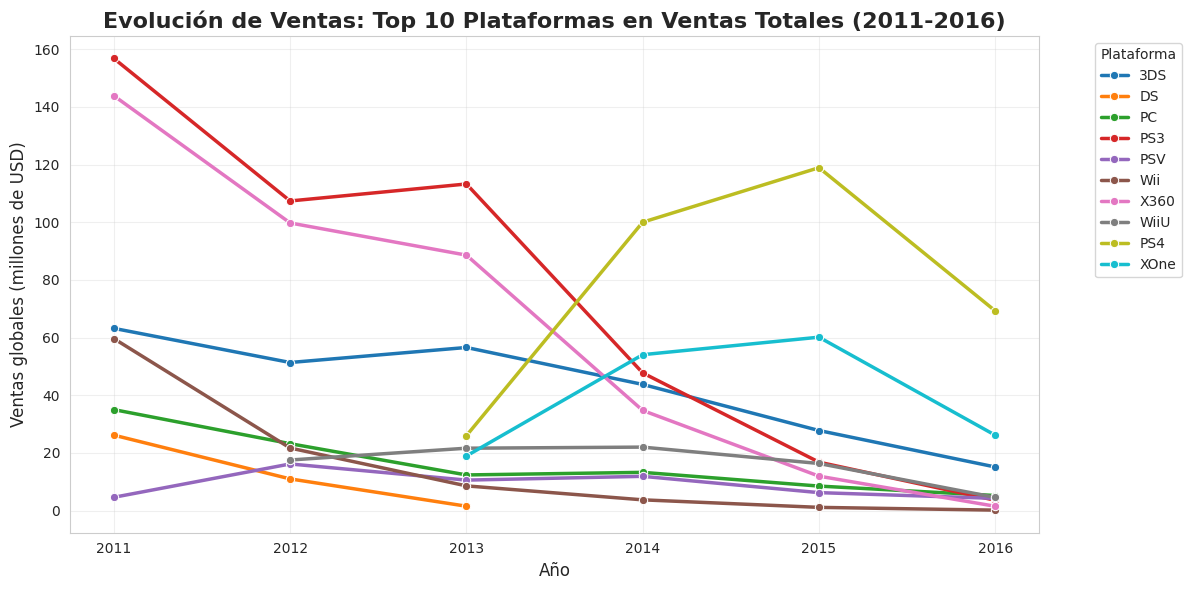

In [ ]:
# graficamos la distribución de las ventas por plataforma por año con un gráfico de líneas múltiples

plt.figure(figsize=(12, 6))
sns.lineplot(data=new_top_platform_sales,
             x='year_of_release',
             y='ventas_totales',
             hue='platform',
             marker='o',
             linewidth=2.5)

# personalizamos
plt.title('Evolución de Ventas: Top 10 Plataformas en Ventas Totales (2011-2016)',
          fontsize=16, fontweight='bold')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Ventas globales (millones de USD)', fontsize=12)
plt.legend(title='Plataforma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Vemos que las plataformas **PS4** y **XOne** estaban en **auge en 2015**, pero en **2016** se unieron a la tendencia de **baja de ventas** de todas las demás plataformas líderes, lo cual va de la mano con una **reducción en la cantidad de juegos publicados** en 2016 respecto de 2015, como vimos en el gráfico de **'Cantidad de juegos lanzados por año'**.

Por lo tanto, considero importante anexar a este análisis un gráfico de la **evolución del score de ventas** de dichas plataformas, para ver su **performance respecto al promedio.**

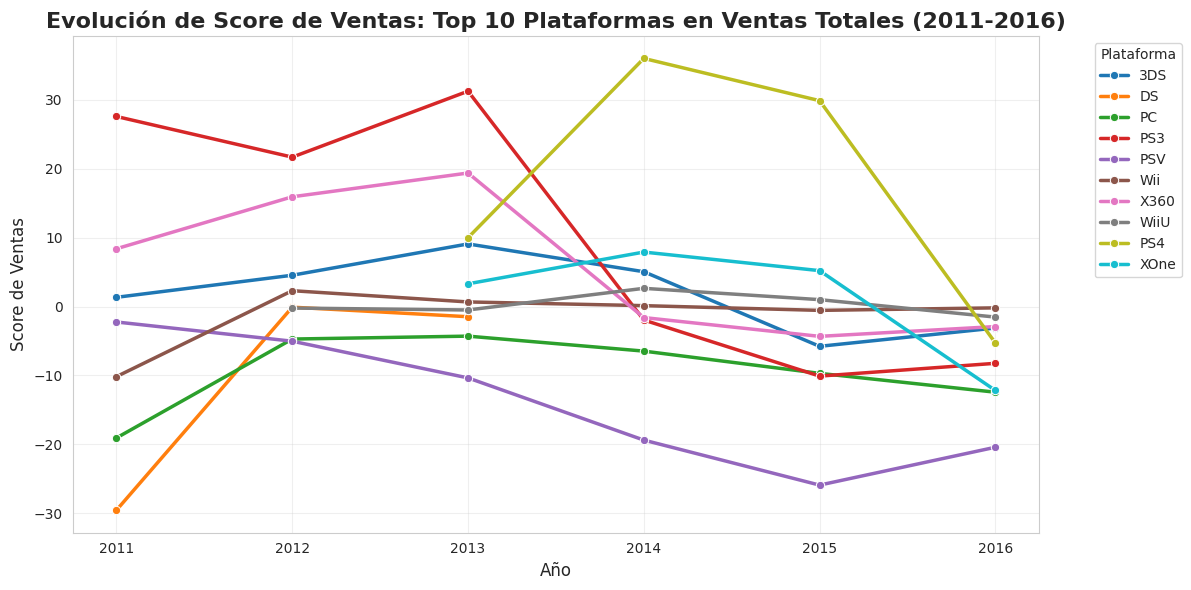

In [ ]:
# datos de cada año
new_top_platform_scores= df_modelo[df_modelo['platform'].isin(new_top_plataformas)].groupby(['year_of_release', 'platform'])['ventas_score'].sum().reset_index()

# graficamos la evolucion del score de ventas de las plataformas top ventas entre 2011 y 2016

plt.figure(figsize=(12, 6))
sns.lineplot(data=new_top_platform_scores,
             x='year_of_release',
             y='ventas_score',
             hue='platform',
             marker='o',
             linewidth=2.5)

# personalizamos
plt.title('Evolución de Score de Ventas: Top 10 Plataformas en Ventas Totales (2011-2016)',
          fontsize=16, fontweight='bold')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Score de Ventas', fontsize=12)
plt.legend(title='Plataforma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Resumen

Tenemos **2 perspectivas complementarias**:

### Gráfico 1: Ventas Totales (2011-2016)
- Para ver el **volumen real** de cada **plataforma**
- Identificar **líderes absolutos** en el mercado
- Ver la **magnitud real** del declive general

### Gráfico 2: Z-scores (2011-2016)
- Para ver **rendimiento relativo** año tras año
- Identificar qué **plataformas ganan o pierden terreno** comparativamente
- Ver cuáles **resisten mejor la tendencia a la baja**

Analizando ambos gráficos, vemos que el año **2013** fue un año de **inflexión**. Algunas plataformas pasaron de **crecer a reducirse** (como **PS3** y **X360**), al tiempo que surgieron **nuevas plataformas** como **PS4** y **XOne**.

Por lo tanto, por más que **actualmente** casi todas las plataformas estén con tendencia a la baja, seleccionaría a **PS4** y **XOne** como plataformas potencialmente rentables.

### Boxplot de ventas totales por plataforma.

/tmp/ipython-input-920562067.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_modelo, x='platform', y='ventas_totales', palette='Set2', linewidth=1.5)


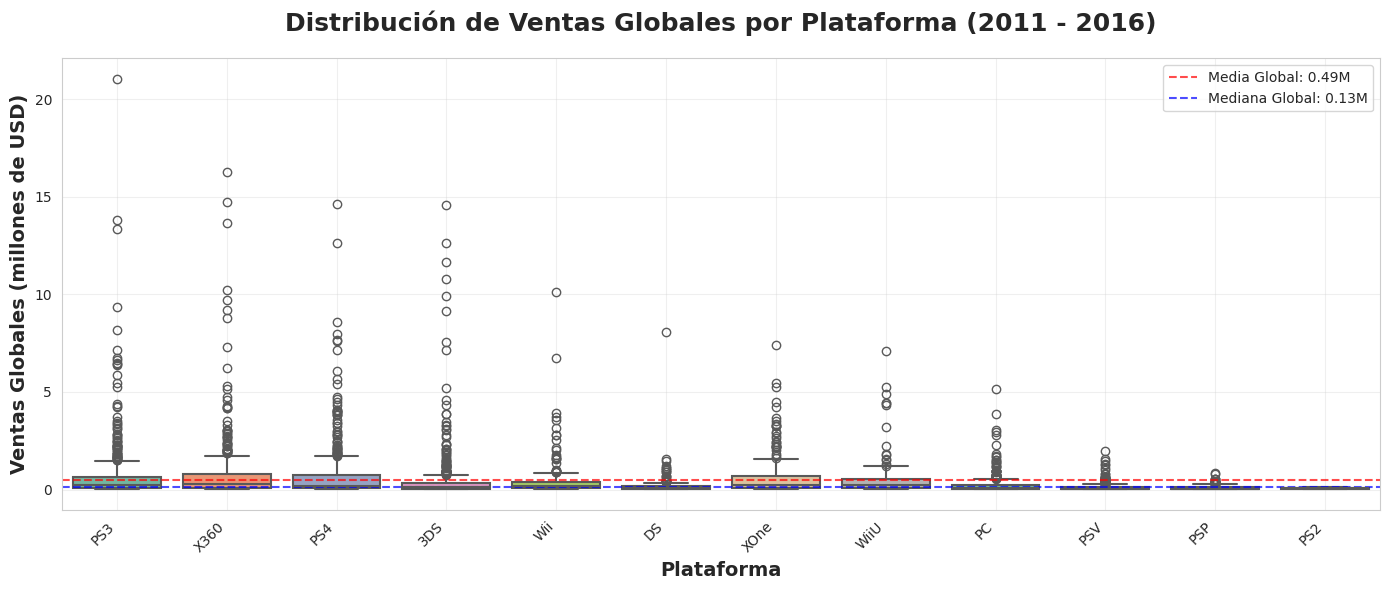

In [ ]:
# creamos el gráfico
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_modelo, x='platform', y='ventas_totales', palette='Set2', linewidth=1.5)

# personalizamos
plt.title('Distribución de Ventas Globales por Plataforma (2011 - 2016)',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Plataforma', fontsize=14, fontweight='bold')
plt.ylabel('Ventas Globales (millones de USD)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# agregamos líneas de referencia de media y mediana
plt.axhline(y=df_modelo['ventas_totales'].mean(), color='red', linestyle='--',
           alpha=0.7, label=f'Media Global: {df_modelo["ventas_totales"].mean():.2f}M')
plt.axhline(y=df_modelo['ventas_totales'].median(), color='blue', linestyle='--',
           alpha=0.7, label=f'Mediana Global: {df_modelo["ventas_totales"].median():.2f}M')

# Agregar leyenda y grid
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Observaciones:**

**¿Son significativas las diferencias en las ventas?**
Sí, **muy significativas:**

- Las plataformas de **consolas principales** (PS3, X360, PS4, XOne) tienen mayor **variabilidad.**

  Esto indica mercados más competitivos donde **algunos juegos explotan en ventas** y otros no.
  
  Las consolas portátiles/especializadas son más consistentes pero con menor potencial

**¿Qué sucede con las ventas promedio vs medianas?**
Distribución **muy sesgada:**

- Medianas cerca de cero = **la mayoría de juegos venden poco**
- Medias más altas = **pocos juegos exitosos elevan el promedio**
- **Outliers extremos** (hasta 22M en PS3) = fenómenos como GTA, FIFA, etc.

### Correlación entre medidas ('critic_score', 'user_score') y 'ventas_totales' para juegos de PS3 y comparación de los mismos juegos en otras plataformas

In [ ]:
# filtramos
ps3_data = df_modelo[df_modelo['platform'] == 'PS3']

print(f"Número de juegos de PS3: {len(ps3_data)}")
print(f"Juegos con Critic_Score disponible: {ps3_data['critic_score'].notna().sum()}")
print(f"Juegos con User_Score disponible: {ps3_data['user_score'].notna().sum()}")

# ver estadísticas básicas
print("\nEstadísticas de las reseñas en PS3:")
print(ps3_data[['critic_score', 'user_score', 'ventas_totales']].describe())

Número de juegos de PS3: 708
Juegos con Critic_Score disponible: 349
Juegos con User_Score disponible: 417

Estadísticas de las reseñas en PS3:
       critic_score  user_score  ventas_totales
count    349.000000  417.000000      708.000000
mean      71.117479    6.612470        0.629336
std       13.487988    1.565075        1.451388
min       13.000000    0.200000        0.010000
25%       63.000000    5.800000        0.070000
50%       73.000000    7.000000        0.210000
75%       81.000000    7.800000        0.640000
max       97.000000    9.100000       21.050000


In [ ]:
# creamos un dataset limpio con las 3 columnas completas
ps3_clean = ps3_data.dropna(subset=['critic_score', 'user_score', 'ventas_totales'])

print(f"Juegos con ambas puntuaciones y datos de venta disponibles: {len(ps3_clean)}")
print(f"Porcentaje del total: {len(ps3_clean)/len(ps3_data)*100:.1f}%")

# Ver la distribución final
print("\nEstadísticas del dataset limpio:")
print(ps3_clean[['critic_score', 'user_score', 'ventas_totales']].describe())

Juegos con ambas puntuaciones y datos de venta disponibles: 342
Porcentaje del total: 48.3%

Estadísticas del dataset limpio:
       critic_score  user_score  ventas_totales
count    342.000000  342.000000      342.000000
mean      71.473684    6.727485        1.004503
std       13.341363    1.456386        1.912134
min       13.000000    1.000000        0.010000
25%       64.000000    6.000000        0.200000
50%       74.000000    7.100000        0.475000
75%       81.000000    7.800000        1.015000
max       97.000000    9.100000       21.050000


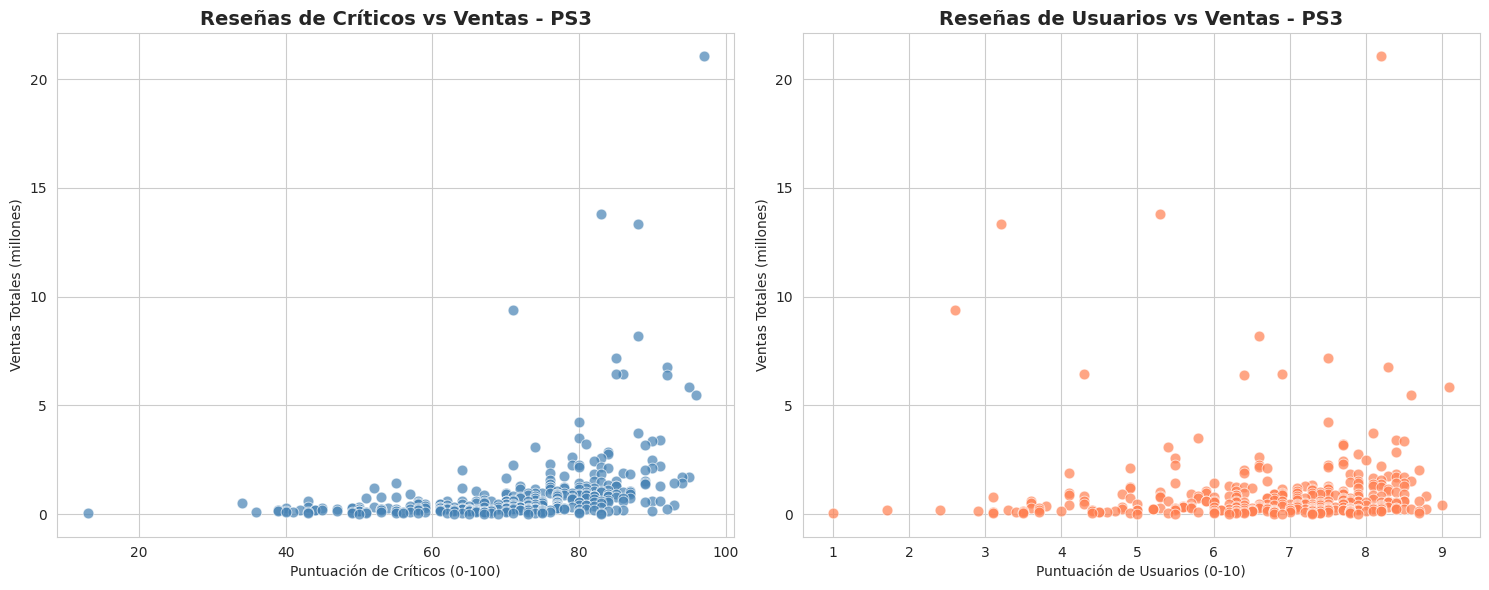

In [ ]:
# procedemos a hacer dos gráficos de dispersión
# uno para critic score vs ventas
# otro para user score vs ventas

# Configurar el estilo de seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

# Subplot 1: Critic Score vs Ventas
plt.subplot(1, 2, 1)
sns.scatterplot(data=ps3_clean, x='critic_score', y='ventas_totales',
                alpha=0.7, s=60, color='steelblue')
plt.title('Reseñas de Críticos vs Ventas - PS3', fontsize=14, fontweight='bold')
plt.xlabel('Puntuación de Críticos (0-100)')
plt.ylabel('Ventas Totales (millones)')

# Subplot 2: User Score vs Ventas
plt.subplot(1, 2, 2)
sns.scatterplot(data=ps3_clean, x='user_score', y='ventas_totales',
                alpha=0.7, s=60, color='coral')
plt.title('Reseñas de Usuarios vs Ventas - PS3', fontsize=14, fontweight='bold')
plt.xlabel('Puntuación de Usuarios (0-10)')
plt.ylabel('Ventas Totales (millones)')

plt.tight_layout()
plt.show()

In [ ]:
# calculamos correlaciones
correlacion_criticos = ps3_clean['critic_score'].corr(ps3_clean['ventas_totales'])
correlacion_usuarios = ps3_clean['user_score'].corr(ps3_clean['ventas_totales'])

print("=== ANÁLISIS DE CORRELACIÓN - PS3 ===")
print(f"Correlación Críticos vs Ventas: {correlacion_criticos:.3f}")
print(f"Correlación Usuarios vs Ventas: {correlacion_usuarios:.3f}")

=== ANÁLISIS DE CORRELACIÓN - PS3 ===
Correlación Críticos vs Ventas: 0.376
Correlación Usuarios vs Ventas: 0.025


Tanto en los gráficos como en el análisis numérico podemos ver que hay una relación positiva entre la puntuación de críticos y las ventas totales: a mayor puntuación, mayor concentración de juegos con ventas más altas, especialmente los outliers.

Por otro lado, vemos que la puntuación de los usuarios prácticamente no influye en la popularidad del juego. Su coeficiente de relación es cercano a cero (casi independientes) y en el gráfico vemos que algunos juegos con ventas muy altas tienen baja reputación entre los usuarios.

En resumen, vemos que la puntuación de los críticos es un punto a valorar por parte de los creadores de videojuegos: ser bien puntuados por ellos otorga buenas chances de que el juego sea más exitoso. Por otro lado, no sugeriría darle mucha importancia a la valoración de los usuarios, ya que no parece influenciar las ventas.

In [ ]:
# analizamos mismos juegos en otras plataformas
juegos_ps3 = df_modelo[df_modelo['name'].isin(ps3_clean['name'])].sort_values(by= 'ventas_totales', ascending= False)


In [ ]:
# encontramos juegos de ps3 que están en múltiples plataformas
juegos_multiplataforma = juegos_ps3.groupby('name')['platform'].nunique()
juegos_con_multiples_plataformas = juegos_multiplataforma[juegos_multiplataforma > 1]

print(f"Juegos disponibles en múltiples plataformas: {len(juegos_con_multiples_plataformas)}")
print("\nEjemplos de juegos multiplataforma:")
print(juegos_con_multiples_plataformas.head(10))

Juegos disponibles en múltiples plataformas: 286

Ejemplos de juegos multiplataforma:
name
2014 FIFA World Cup Brazil           2
Ace Combat: Assault Horizon          2
Alice: Madness Returns               3
Aliens: Colonial Marines             3
Anarchy Reigns                       2
Angry Birds Star Wars                8
Angry Birds Trilogy                  3
Ar Nosurge: Ode to an Unborn Star    2
Arcana Heart 3                       3
Armored Core V                       2
Name: platform, dtype: int64


In [ ]:
print("\nPrimeros juegos multiplataforma con sus plataformas:")
for juego in juegos_con_multiples_plataformas.head(5).index:
    plataformas = juegos_ps3[juegos_ps3['name'] == juego][['platform', 'ventas_totales']].sort_values('ventas_totales', ascending=False)
    print(f"\n{juego}:")
    print(plataformas)


Primeros juegos multiplataforma con sus plataformas:

2014 FIFA World Cup Brazil:
     platform  ventas_totales
3271      PS3            0.61
4550     X360            0.43

Ace Combat: Assault Horizon:
     platform  ventas_totales
2770      PS3            0.74
4035     X360            0.49

Alice: Madness Returns:
     platform  ventas_totales
3452      PS3            0.58
4005     X360            0.49
9905       PC            0.12

Aliens: Colonial Marines:
     platform  ventas_totales
2641     X360            0.77
3328      PS3            0.60
8119       PC            0.18

Anarchy Reigns:
     platform  ventas_totales
7511      PS3            0.21
8365     X360            0.17


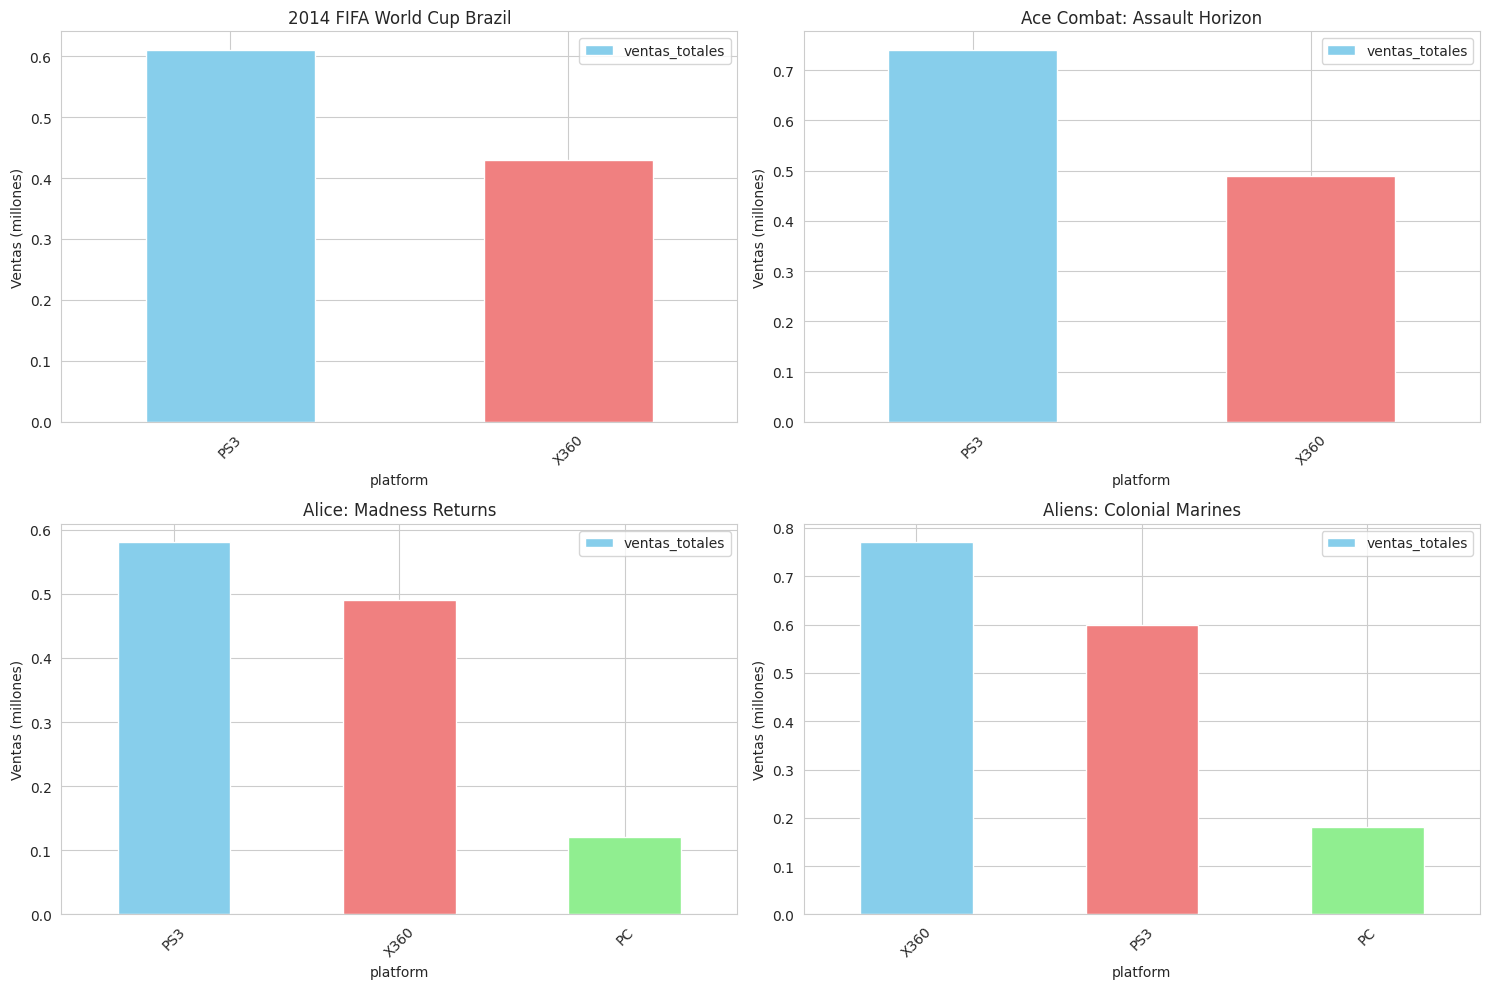

In [ ]:
# seleccionamos algunos juegos representativos para visualizar
juegos_analizar = ['2014 FIFA World Cup Brazil', 'Ace Combat: Assault Horizon',
                   'Alice: Madness Returns', 'Aliens: Colonial Marines']

# creamos un gráfico de barras comparativo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, juego in enumerate(juegos_analizar):
    data = juegos_ps3[juegos_ps3['name'] == juego][['platform', 'ventas_totales']]
    data.plot(x='platform', y='ventas_totales', kind='bar', ax=axes[i],
              title=f'{juego}', color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[i].set_ylabel('Ventas (millones)')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Observaciones clave en los datos:

- **PS3 vs Xbox 360:** En la mayoría de los casos PS3 supera a X360 (FIFA, Ace Combat, Alice: Madness Returns), pero en otros X360 gana (ej. Aliens: Colonial Marines)
- **PC como tercera opción:** Consistentemente tiene ventas más bajas
- **Variabilidad significativa:** Las diferencias entre plataformas son sustanciales

### Distribución de géneros y cuáles tienen mayores ventas totales (más exitosos)

In [ ]:
# análisis de rentabilidad y distribución por género
# ventas totales y promedio por género, y cantidad de juegos publicados
generos_ventas = df_modelo.groupby('genre')['ventas_totales'].agg(['sum', 'mean', 'count']).round(2)
generos_ventas.columns = ['ventas_totales', 'ventas_promedio', 'cantidad_juegos']
generos_ventas = generos_ventas.sort_values('ventas_totales', ascending=False)

print("Análisis de rentabilidad por género:")
print(generos_ventas)

Análisis de rentabilidad por género:
              ventas_totales  ventas_promedio  cantidad_juegos
genre                                                         
Action                557.80             0.44             1269
Shooter               402.91             1.22              329
Role-Playing          245.63             0.53              465
Sports                237.15             0.61              389
Misc                  139.42             0.37              375
Platform               88.68             0.73              122
Racing                 88.31             0.49              180
Fighting               66.90             0.42              159
Simulation             50.26             0.37              136
Adventure              45.04             0.11              410
Strategy               22.16             0.19              117
Puzzle                  9.85             0.14               71


/tmp/ipython-input-3286807768.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=generos_ventas, x='genre', y= generos_ventas['cantidad_juegos'], palette='Set2')


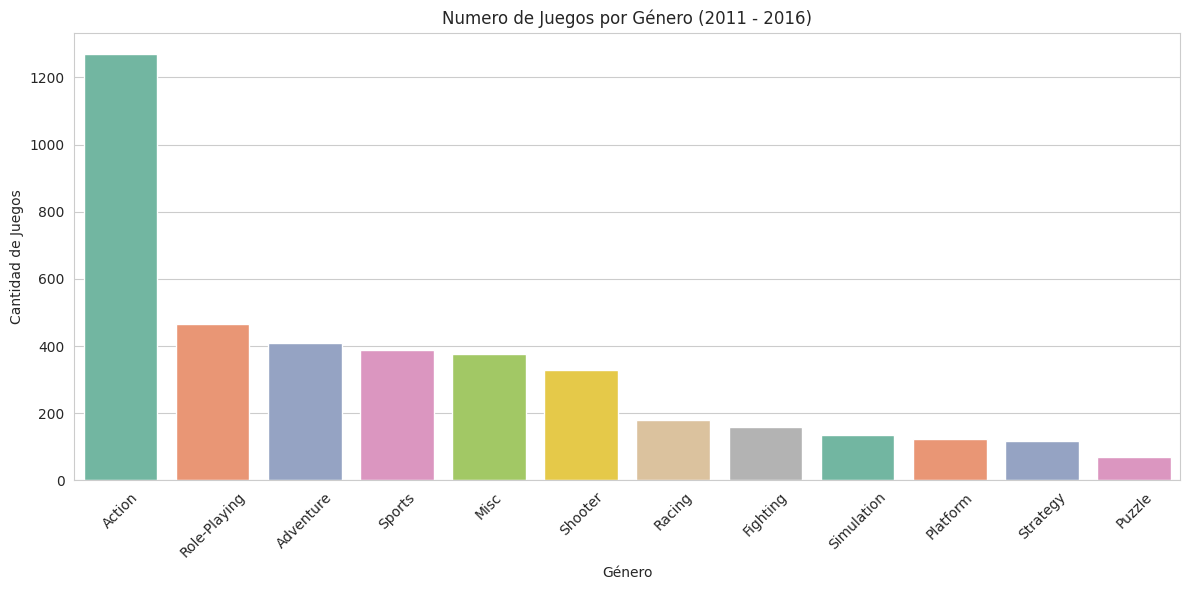

In [ ]:
# visualizamos cantidad de juegos
generos_ventas = generos_ventas.sort_values('cantidad_juegos', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=generos_ventas, x='genre', y= generos_ventas['cantidad_juegos'], palette='Set2')
plt.title('Numero de Juegos por Género (2011 - 2016)')
plt.xlabel('Género')
plt.ylabel('Cantidad de Juegos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1311561504.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=generos_ventas, x='genre', y= generos_ventas['ventas_totales'], palette='Set2')


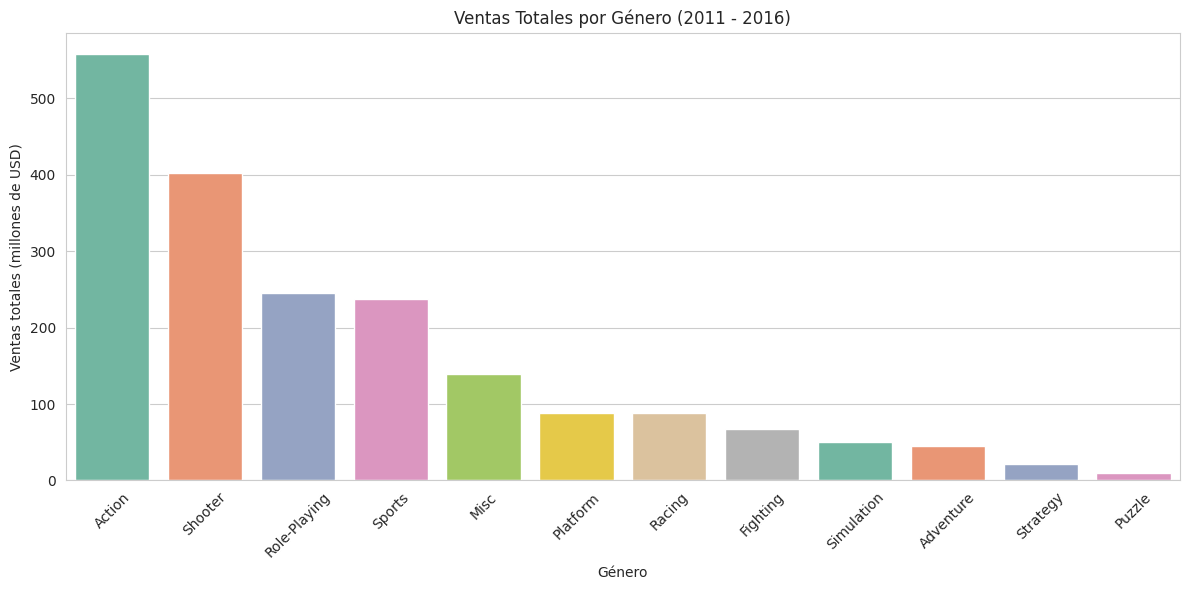

In [ ]:
# visualizamos ventas totales
generos_ventas = generos_ventas.sort_values('ventas_totales', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=generos_ventas, x='genre', y= generos_ventas['ventas_totales'], palette='Set2')
plt.title('Ventas Totales por Género (2011 - 2016)')
plt.xlabel('Género')
plt.ylabel('Ventas totales (millones de USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1204700667.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=generos_ventas, x='genre', y= generos_ventas['ventas_promedio'], palette='Set2')


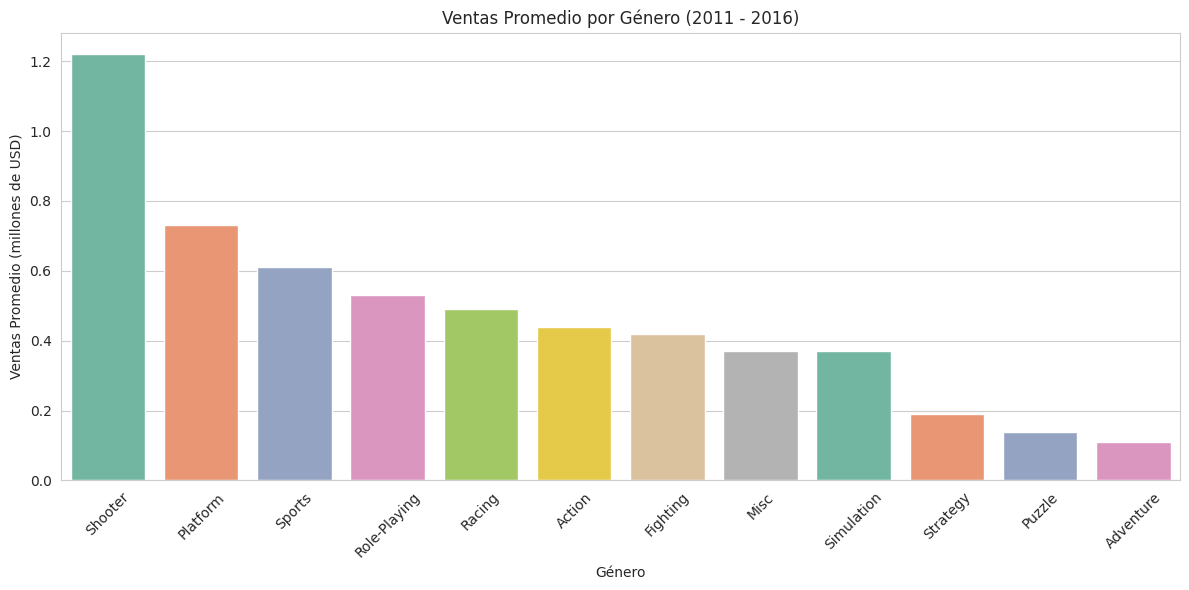

In [ ]:
# visualizamos ventas promedio
generos_ventas = generos_ventas.sort_values('ventas_promedio', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=generos_ventas, x='genre', y= generos_ventas['ventas_promedio'], palette='Set2')
plt.title('Ventas Promedio por Género (2011 - 2016)')
plt.xlabel('Género')
plt.ylabel('Ventas Promedio (millones de USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Conclusiones parciales

**Ventas totales vs. ventas promedio**

- **Ventas totales:** *Action, Shooter, Role-Playing* dominan porque tienen muchos juegos en el mercado (son el top 3 de ventas totales Y de cantidad de juegos lanzados)
- **Ventas promedio:** *Shooter, Platform, Sports* nos dice que estos géneros, aunque tal vez tengan menos juegos, cada uno vende muy bien en promedio.

**Observaciones:**

- **Shooter es consistente**: aparece en ambos tops, lo que sugiere que es un género tanto popular como exitoso por juego.
- **Platform y Sports**: están en top 3 de promedio pero más abajo en totales (6to y 4to), lo que indica que son géneros más "nicho" pero muy exitosos.
- **Los géneros del fondo coinciden** en ambas métricas, sugiriendo que realmente tienen menor penetración en el mercado.

## Paso 4 - Crear un perfil de usuario para cada región

Para **cada región (NA, UE, JP)** determinaremos:

- Las **cinco plataformas principales** y sus **cuotas de mercado.**
- Los **cinco géneros principales.**
- Influencia de **clasificaciones de ESRB.**

### Las cinco plataformas principales y sus cuotas de mercado.

In [ ]:
# preparamos los datos
df_modelo_na= df_modelo[['name', 'platform', 'genre', 'rating', 'rating_num', 'na_sales']]
df_modelo_na.columns = ['name', 'platform', 'genre', 'rating', 'rating_num', 'ventas']

df_modelo_eu= df_modelo[['name', 'platform', 'genre', 'rating', 'rating_num', 'eu_sales']]
df_modelo_eu.columns = ['name', 'platform', 'genre', 'rating', 'rating_num', 'ventas']

df_modelo_jp= df_modelo[['name', 'platform', 'genre', 'rating', 'rating_num', 'jp_sales']]
df_modelo_jp.columns = ['name', 'platform', 'genre', 'rating', 'rating_num', 'ventas']

In [ ]:
# Diccionario para almacenar los datos
datos_plataformas_principales = {
    'Platform': [],
    'NA': [],
    'EU': [],
    'JP': []
}

def plataformas_principales(data, region):
    # Obtener top 5 plataformas y sus ventas
    ventas_por_plataforma = data.groupby('platform')['ventas'].sum().sort_values(ascending=False).head(5)

    # Agregar las plataformas y ventas al diccionario
    for platform, ventas in ventas_por_plataforma.items():
        if platform not in datos_plataformas_principales['Platform']:
            datos_plataformas_principales['Platform'].append(platform)
            # Inicializar con 0 para todas las regiones
            datos_plataformas_principales['NA'].append(0)
            datos_plataformas_principales['EU'].append(0)
            datos_plataformas_principales['JP'].append(0)

        # Encontrar el índice de la plataforma y actualizar la región correspondiente
        idx = datos_plataformas_principales['Platform'].index(platform)
        datos_plataformas_principales[region][idx] = ventas

    # Mostrar resultados
    print(f"Top 5 plataformas principales en la región: {region}")
    print(ventas_por_plataforma.reset_index(name='ventas_totales'))
    print()
    print(f"Cuotas de mercado:")
    print(ventas_por_plataforma / data['ventas'].sum())
    print("-" * 50)

# Ejecutar para las tres regiones
plataformas_principales(df_modelo_na, 'NA')
plataformas_principales(df_modelo_eu, 'EU')
plataformas_principales(df_modelo_jp, 'JP')

# Crear el DataFrame final
df_ventas = pd.DataFrame(datos_plataformas_principales)
print("DataFrame consolidado:")
print(df_ventas)

Top 5 plataformas principales en la región: NA
  platform  ventas_totales
0     X360          226.80
1      PS3          168.26
2      PS4          108.74
3     XOne           93.12
4      3DS           82.65

Cuotas de mercado:
platform
X360    0.273332
PS3     0.202782
PS4     0.131050
XOne    0.112225
3DS     0.099607
Name: ventas, dtype: float64
--------------------------------------------------
Top 5 plataformas principales en la región: EU
  platform  ventas_totales
0      PS3          163.10
1      PS4          141.09
2     X360          117.10
3      3DS           61.27
4       PC           56.70

Cuotas de mercado:
platform
PS3     0.243509
PS4     0.210648
X360    0.174831
3DS     0.091476
PC      0.084653
Name: ventas, dtype: float64
--------------------------------------------------
Top 5 plataformas principales en la región: JP
  platform  ventas_totales
0      3DS          100.62
1      PS3           49.39
2      PSP           24.04
3      PSV           21.84
4      PS4  

In [ ]:
# transformamos los datos de tipo wide a long
df_melted = df_ventas.melt(id_vars='Platform',
                          value_vars=['NA', 'EU', 'JP'],
                          var_name='Region',
                          value_name='Ventas')

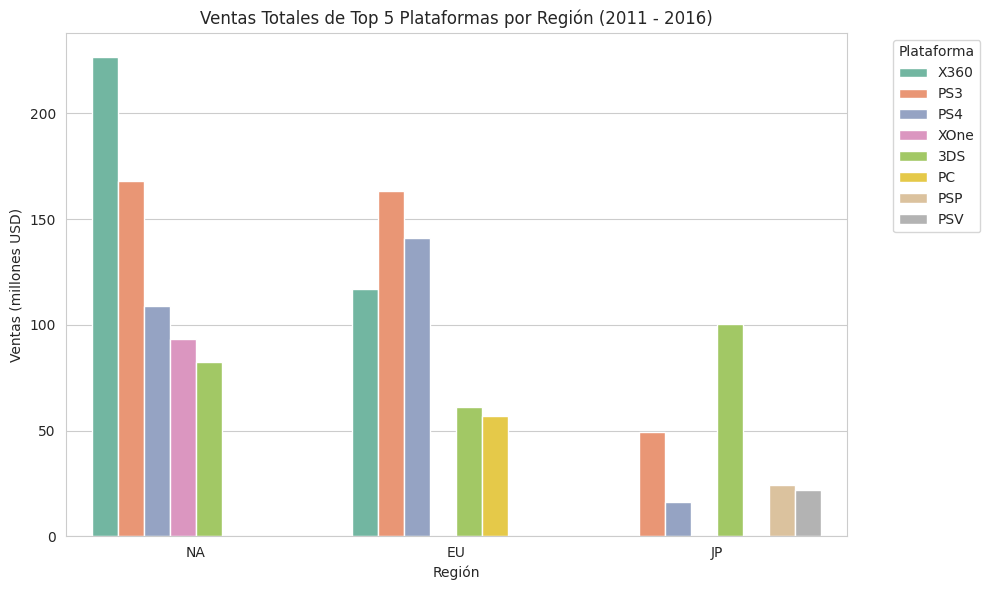

In [ ]:
# gráfico de barras agrupadas: regiones en X, plataformas agrupadas
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Region', y='Ventas', hue='Platform', palette= 'Set2')
plt.title('Ventas Totales de Top 5 Plataformas por Región (2011 - 2016)')
plt.xlabel('Región')
plt.ylabel('Ventas (millones USD)')
plt.legend(title='Plataforma', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Observaciones parciales:

En **Norteamérica**, la **Xbox 360** domina ampliamente con una cuota del **27,3%**, seguida por **PS3 (20,3%)** y **PS4 (13,1%)**. Esto muestra una clara preferencia por las **consolas de Microsoft**, algo típico del mercado estadounidense, donde Xbox siempre tuvo fuerte presencia.

En **Europa**, el liderazgo cambia: la **PS3** encabeza con un **24,3%**, seguida por **PS4 (21,1%)** y **Xbox 360 (17,5%)**. Aquí las consolas de **Sony** mantienen una posición más sólida, reflejando una tendencia europea hacia la marca **PlayStation.**

En **Japón**, el panorama es **completamente distinto**. La **Nintendo 3DS** domina con un **40,9%**, mientras que la **PS3** pisa fuerte con una cuota del **20,1%** y más lejos aparecen consolas portátiles como **PSP (9,8%)** y **PSV (8,9%)**. Las plataformas occidentales como Xbox 360 o Xbox One prácticamente no tienen presencia.

Entre las diferencias más notables, se observa que **las consolas japonesas (3DS, PSP, PSV) son muy populares en su propio mercado**, pero marginales en Occidente, mientras que las **Xbox** tienen el c**omportamiento opuesto**: fuertes en NA, débiles en JP.

Respecto a **PlayStation**, mantiene una **presencia equilibrada a nivel global**, liderando en Europa, siendo segunda en NA y teniendo buena aceptación en Japón (aunque detrás de Nintendo).

### Los cinco géneros principales.

In [ ]:
# ahora evaluamos géneros principales
# Diccionario para almacenar los datos
datos_generos_principales = {
    'Genre': [],
    'NA': [],
    'EU': [],
    'JP': []
}

def generos_principales(data, region):
    # Obtener top 5 géneros y sus ventas
    ventas_por_genero = data.groupby('genre')['ventas'].sum().sort_values(ascending=False).head(5)

    # Agregar las plataformas y ventas al diccionario
    for genre, ventas in ventas_por_genero.items():
        if genre not in datos_generos_principales['Genre']:
            datos_generos_principales['Genre'].append(genre)
            # Inicializar con 0 para todas las regiones
            datos_generos_principales['NA'].append(0)
            datos_generos_principales['EU'].append(0)
            datos_generos_principales['JP'].append(0)

        # Encontrar el índice del género y actualizar la región correspondiente
        idx = datos_generos_principales['Genre'].index(genre)
        datos_generos_principales[region][idx] = ventas

    # Mostrar resultados
    print(f"Top 5 géneros principales en la región: {region}")
    print(ventas_por_genero.reset_index(name='ventas_totales'))
    print("-" * 50)

# Ejecutar para las tres regiones
generos_principales(df_modelo_na, 'NA')
generos_principales(df_modelo_eu, 'EU')
generos_principales(df_modelo_jp, 'JP')

# Crear el DataFrame final
df_ventas_genre = pd.DataFrame(datos_generos_principales)
print("DataFrame consolidado:")
print(df_ventas_genre)

Top 5 géneros principales en la región: NA
          genre  ventas_totales
0        Action          230.92
1       Shooter          194.43
2        Sports          108.70
3  Role-Playing           83.78
4          Misc           69.69
--------------------------------------------------
Top 5 géneros principales en la región: EU
          genre  ventas_totales
0        Action          199.12
1       Shooter          148.02
2        Sports           88.48
3  Role-Playing           62.30
4        Racing           40.58
--------------------------------------------------
Top 5 géneros principales en la región: JP
          genre  ventas_totales
0  Role-Playing           79.87
1        Action           63.62
2          Misc           17.60
3      Fighting           12.38
4      Platform           12.13
--------------------------------------------------
DataFrame consolidado:
          Genre      NA      EU     JP
0        Action  230.92  199.12  63.62
1       Shooter  194.43  148.02   0.00
2 

In [ ]:
# transformamos los datos de tipo wide a long
df_melted2 = df_ventas_genre.melt(id_vars='Genre',
                          value_vars=['NA', 'EU', 'JP'],
                          var_name='Region',
                          value_name='Ventas')

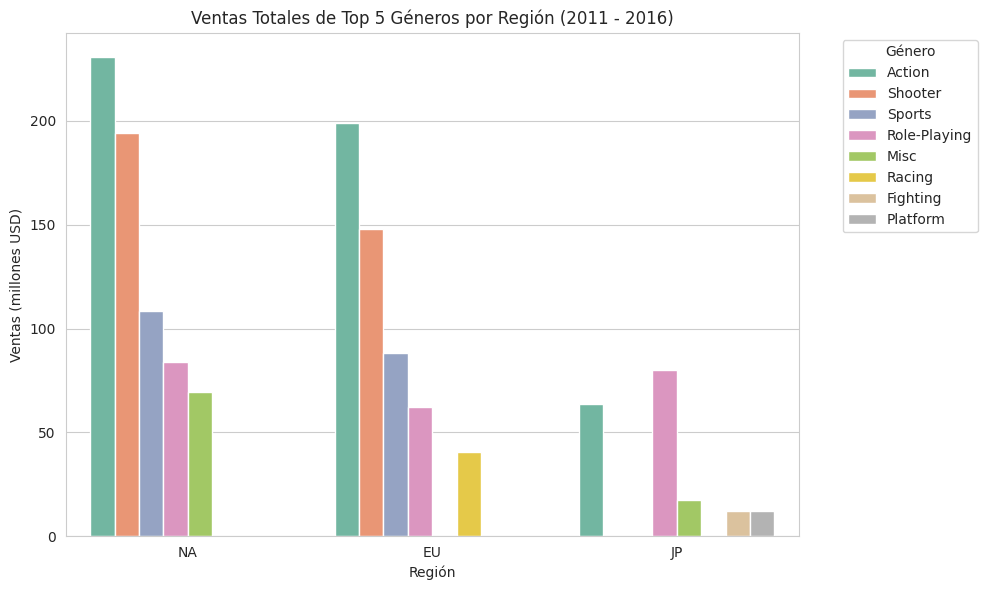

In [ ]:
# gráfico de barras agrupadas: regiones en X, géneros agrupados
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted2, x='Region', y='Ventas', hue='Genre', palette= 'Set2')
plt.title('Ventas Totales de Top 5 Géneros por Región (2011 - 2016)')
plt.xlabel('Región')
plt.ylabel('Ventas (millones USD)')
plt.legend(title='Género', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Observaciones parciales:

En **Norteamérica**, los **géneros más vendidos** son **Action (230,9M)** y **Shooter (194,4M)**, seguidos por **Sports (108,7M)**. Esto refleja una clara inclinación hacia los **juegos dinámicos y competitivos**, típicos del público occidental.

En **Europa**, el **patrón** es **parecido**: **Action (199,1M)** y **Shooter (148M) dominan**, con **Sports (88,5M)** en **tercer lugar**. Sin embargo, se observa **presencia** de géneros como **Racing**, más popular que en NA.

En **Japón**, la situación **cambia por completo**: los **Role-Playing games (79,9M)** son los **líderes absolutos**, **seguidos por Action (63,6M)** y **Misc/Fighting/Platform**, todos con **cifras mucho menores**. Esto evidencia la fuerte tradición japonesa en juegos de rol y aventuras narrativas.

Entre las **diferencias más notables**:

- **Shooter y Sport** son **muy populares en Occidente**, pero **casi inexistentes en Japón.**

- **Role-Playing** tiene **buena presencia global**, aunque solo en Japón es el género dominante.

- **Racing y Fighting** muestran **patrones regionales más específicos** (Europa y Japón, respectivamente).

👉 En conjunto, los datos muestran cómo las preferencias de género siguen una línea cultural clara: Occidente busca adrenalina y competencia, mientras que Japón prioriza la historia y la jugabilidad profunda.

### Influencia de clasificaciones de ESRB.

Utilizaremos la correlación de Spearman ya que, en vez de fijarse en los valores exactos, Spearman ordena los datos (de menor a mayor) y compara si los rankings suben o bajan juntos.

In [ ]:
# calculamos la correlación (Spearman) entre `'rating_num'` y `'ventas'` para cada región
def calcular_correlacion(df, region):
    corr, p_value = stats.spearmanr(df['rating_num'], df['ventas'])
    print(f"Para la región de: {region}")
    print(f"Correlación de Spearman entre la clasificación ESRB y las ventas totales: {corr:.3f}")
    print(f"p-valor: {p_value:.4f}") # probabilidad de que la correlación sea sólo coincidencia
    print("-" * 50)

calcular_correlacion(df_modelo_na, 'NA')
calcular_correlacion(df_modelo_eu, 'EU')
calcular_correlacion(df_modelo_jp, 'JP')

Para la región de: NA
Correlación de Spearman entre la clasificación ESRB y las ventas totales: 0.521
p-valor: 0.0000
--------------------------------------------------
Para la región de: EU
Correlación de Spearman entre la clasificación ESRB y las ventas totales: 0.496
p-valor: 0.0000
--------------------------------------------------
Para la región de: JP
Correlación de Spearman entre la clasificación ESRB y las ventas totales: -0.213
p-valor: 0.0000
--------------------------------------------------


### Observaciones parciales:

En **Norteamérica y Europa**, la **correlación positiva** (0.52 y 0.49) indica que los **juegos** con clasificación más alta —es decir, orientados a **público adolescente o adulto**— tienden a **vender mejor**. Esto sugiere que en los mercados occidentales **predominan** los **consumidores mayores**, interesados en títulos más complejos o violentos como Call of Duty o GTA.

En cambio, en **Japón** la **correlación es negativa** (-0.21), lo que significa que **los juegos con clasificación más baja (para todo público)** son los que **más venden**. Esto coincide con la fuerte presencia de sagas familiares o de rol accesible, como Pokémon o Animal Crossing.

## Paso 5 - Pruebas de Hipótesis

A — "Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas."

B — "Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes."

Definimos el valor de **alpha** en **0.05**

### Comencemos por la Prueba de Hipótesis A:

- Hipótesis nula: "Las **calificaciones promedio** de los usuarios para las **plataformas Xbox One y PC** son las mismas."

- Hipótesis alternativa: "Las **calificaciones promedio** de los usuarios para las **plataformas Xbox One y PC** son diferentes."

- Prueba estadística: "Prueba t bilateral de dos muestras independientes", ya que de esta forma averiguamos la probabilidad de que la diferencia que se observa entre las medias de dos poblaciones sea casualidad o efectivamente pueda significar una diferencia significativa entre ellas.

In [ ]:
# antes de realizar la prueba, averiguamos la media de ambas muestras y sus desviaciones estándar, para tener una idea de su distribución
# preparamos los datos
# recordemos que la columna user_score tenía valores ausentes, por lo que los eliminaremos en este paso
xbox_one_data = df_modelo[df_modelo['platform'] == 'XOne'].dropna(subset=['user_score'])['user_score']
pc_data = df_modelo[df_modelo['platform'] == 'PC'].dropna(subset=['user_score'])['user_score']

print("Estadísticas descriptivas:\n")
print(f"Xbox One: {xbox_one_data.describe()}")
print()
print(f"PC: {pc_data.describe()}")

Estadísticas descriptivas:

Xbox One: count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

PC: count    307.000000
mean       6.451792
std        1.611303
min        1.400000
25%        5.550000
50%        6.800000
75%        7.700000
max        9.300000
Name: user_score, dtype: float64


- Confirmamos que las muestras son los suficientemente grandes para realizar una prueba t (182 y 307 elementos)
- Vemos que las desviaciones estándar son bastante similares (1.38 vs 1.61), por lo que para la prueba t las asumiremos como iguales.

In [ ]:
# prueba estadística
alpha = 0.05
t_a, p_a = st.ttest_ind(xbox_one_data, pc_data) # valor estadístico 'a', y valor p 'a'. 'a' porque es la prueba A

print("Hipótesis nula A: 'Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.'")
print('p-valor:', p_a)
print()

if p_a < alpha:
    print("Rechazamos la hipótesis nula. Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son DIFERENTES.")
else:
    print("No rechazamos la hipótesis nula. Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC puede que sean IGUALES.")
    print("Valor estadístico de la prueba A:", t_a)


Hipótesis nula A: 'Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.'
p-valor: 0.6267602271422398

No rechazamos la hipótesis nula. Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC puede que sean IGUALES.
Valor estadístico de la prueba A: 0.48660071309601444


El p-valor de nuestra prueba de hipótesis es muy alto (0.63) respecto a nuestro valor de significancia (0.05), lo cual indica que los usuarios valoran los juegos de Xbox One y PC prácticamente igual, y cualquier diferencia observada se puede explicar por el azar de la muestra, no por una diferencia real entre plataformas.

### Pasemos a la Prueba de Hipótesis B:


- Hipótesis nula: "Las **calificaciones promedio** de los usuarios para los **géneros de Acción y Deportes** son iguales."

- Hipótesis alternativa: "Las **calificaciones promedio** de los usuarios para los **géneros de Acción y Deportes** son diferentes."

- Prueba estadística: "Prueba t bilateral de dos muestras independientes", ya que de esta forma averiguamos la probabilidad de que la diferencia que se observa entre las medias de dos poblaciones sea casualidad o efectivamente pueda significar una diferencia significativa entre ellas.

In [ ]:
# antes de realizar la prueba, averiguamos la media de ambas muestras y sus desviaciones estándar, para tener una idea de su distribución
# preparamos los datos
# recordemos que la columna user_score tenía valores ausentes, por lo que los eliminaremos en este paso
action_data = df_modelo[df_modelo['genre'] == 'Action'].dropna(subset=['user_score'])['user_score']
sports_data = df_modelo[df_modelo['genre'] == 'Sports'].dropna(subset=['user_score'])['user_score']

print("Estadísticas descriptivas:\n")
print(f"Xbox One: {action_data.describe()}")
print()
print(f"PC: {sports_data.describe()}")

Estadísticas descriptivas:

Xbox One: count    664.000000
mean       6.775904
std        1.346060
min        1.600000
25%        6.100000
50%        7.100000
75%        7.800000
max        9.100000
Name: user_score, dtype: float64

PC: count    246.000000
mean       5.650813
std        1.697795
min        0.200000
25%        4.400000
50%        6.000000
75%        6.900000
max        8.800000
Name: user_score, dtype: float64


- Confirmamos que las muestras son los suficientemente grandes para realizar una prueba t (664 y 246 elementos)
- Vemos que las desviaciones estándar son bastante similares (1.35 vs 1.7), por lo que para la prueba t las asumiremos como iguales.

In [ ]:
# prueba estadística
alpha = 0.05
t_b, p_b = st.ttest_ind(action_data, sports_data)
print("Hipótesis nula B: 'Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son iguales.'")
print('p-valor:', p_b)
print()

if p_b < alpha:
    print("Rechazamos la hipótesis nula. Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son DIFERENTES.")
else:
    print("No rechazamos la hipótesis nula. Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC puede que sean IGUALES.")
    print("Valor estadístico de la prueba A:", t_b)

Hipótesis nula B: 'Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son iguales.'
p-valor: 5.1974550252152054e-24

Rechazamos la hipótesis nula. Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son DIFERENTES.


La prueba t mostró un p-valor < 0.05, indicando que las calificaciones promedio de los géneros Acción y Deportes difieren significativamente. Los juegos de Acción obtienen, en promedio, puntuaciones de usuario más altas que los de Deportes.

## Conclusiones Finales

El análisis de datos de ventas y calificaciones de videojuegos entre 1980 y 2016 permitió identificar **patrones clave de comportamiento** del mercado global y **diferencias culturales** marcadas entre regiones.

### 1. **Tendencias generales y plataformas**

Las plataformas tienen un ciclo de vida promedio de ~10 años, alcanzando su punto máximo alrededor del cuarto año tras su lanzamiento. Entre **2011 y 2016**, las consolas **PS4 y Xbox One** se consolidaron como las **más prometedoras**, mientras que generaciones previas como PS3 y X360 entraron en declive. En **Japón**, sin embargo, las **consolas portátiles y de Nintendo** (3DS, PSP, PSV) mantuvieron el liderazgo, reflejando una preferencia por la movilidad y el desarrollo local.

### 2. **Preferencias por género**

Los géneros **Action y Shooter** dominaron las ventas en **Norteamérica y Europa**, mientras que **Role-Playing** (RPG) lideró ampliamente en **Japón**. Esto confirma un **patrón cultural** claro:

- **Occidente** busca juegos **competitivos, de acción y ritmo rápido**.

- **Japón** prioriza **historias, progresión narrativa y jugabilidad profunda**.

### 3. **Influencia del rating ESRB**

La **correlación positiva** entre el **rating ESRB** y las **ventas** en **NA** (ρ=0.52) y **EU** (ρ=0.49) indica que los **juegos dirigidos a público adolescente y adulto** son los **más exitosos en Occidente**. En contraste, **Japón** (ρ=-0.21) muestra una **preferencia por títulos aptos para todo público**, reforzando su tendencia hacia franquicias familiares.

### 4. **Calificaciones y percepción del usuario**

Las **reseñas de críticos** se **correlacionan de forma más clara** con las **ventas** que las **puntuaciones de usuarios**, lo que sugiere que la valoración profesional influye más en la decisión de compra.

Además, las **pruebas de hipótesis** mostraron que:

- **No hay diferencia significativa en las calificaciones promedio entre Xbox One y PC** (p=0.63).

- **Sí existe una diferencia significativa entre los géneros Acción y Deportes** (p≈0), con mejores valoraciones para los juegos de Acción.

### 5. **Conclusión general**

El **mercado de videojuegos** es altamente **segmentado y dinámico.**

Las **preferencias** varían según la **región** y el **tipo de público**, pero en general **los títulos de acción, con buena crítica y orientados a un público más adulto, tienen mayores probabilidades de éxito comercial.**

Para una **campaña publicitaria enfocada en 2017**, se recomendaría priorizar:

- **PS4 y Xbox One como plataformas principales.**

- **Géneros de Acción y Shooter, especialmente con temáticas maduras.**

- **Destacar las reseñas positivas de críticos en el marketing.**

- **Adaptar la oferta al mercado japonés con juegos RPG o familiares.**